# Lab 2 TD

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op

## 1. The data

In [2]:
# Load the dataset
# The first two columns contains the exam scores and the third column
# contains the label.
data = np.loadtxt('data1.txt', delimiter=',')
 
X = data[:, 0:2]
y = data[:, 2]

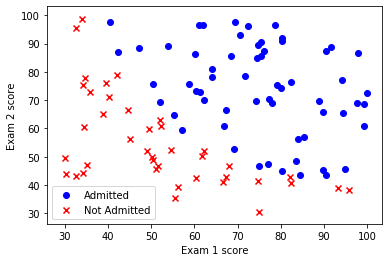

In [3]:
# Plot data 
pos = np.where(y == 1)
neg = np.where(y == 0)
plt.scatter(X[pos, 0], X[pos, 1], marker='o', c='b')
plt.scatter(X[neg, 0], X[neg, 1], marker='x', c='r')
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend(['Admitted', 'Not Admitted'])
plt.show()

In [4]:
#Add intercept term to X
X_new = np.ones((X.shape[0], 3))
X_new[:, 1:] = X
X = X_new

## 2. What is logistic regression 

Logistic regression may be explained from a probabilistic perspective. 

Let us denote $x_{1:m}, y_{1:m} \sim X, Y$ i.i.d observations of $X \in \mathbb{R}^p, Y \in \{0,1\}$.

### The model

Let us consider the following regression model to explain the data
\begin{equation*}
    P_{Y|X=x} = \mathrm{Ber}(p = \sigma(x^\top \theta))
\end{equation*}

### Maximizing the likelihood
Under this model, the probability of observing $(x_i, y_i)$ is
\begin{align*}
    p_{Y|X=x_i}(y_i) &= p^{y_i} (1-p)^{1-y_i} \\
    &= \sigma(x_i^\top\theta)^{y_i} (1-\sigma(x_i^\top\theta))^{1-y_i}
\end{align*}

The optimal value of $\theta$ is chosen to maximize the likelihood of observations that is
\begin{align*}
    \theta^* &= \underset{\theta}{\text{arg max}} \prod_{i=1}^m p_{Y|X=x_i}(y_i) \\
    &= \underset{\theta}{\text{arg max}} \sum_{i=1}^m \log p_{Y|X=x_i}(y_i) \\
    &= \underset{\theta}{\text{arg max}} \sum_{i=1}^m y_i \log \sigma(\theta^\top x_i) + (1-y_i) \log (1-\sigma(\theta^\top x_i)) \\
    &= \underset{\theta}{\text{arg min}} -\frac{1}{m} \sum_{i=1}^m y_i \log \sigma(\theta^\top x_i) + (1-y_i) \log (1-\sigma(\theta^\top x_i)) \\
    &= \underset{\theta}{\text{arg min}} \quad J(\theta)
\end{align*}

## 3. Implementation

### 3.1 The sigmoid

In [5]:
# Sigmoid function
def sigmoid(z):
    return 1/(1+np.exp(-z))

# Logit function
def logit(z):
    return np.log(z/(1-z))

In [6]:
def test_sigmoid():
    # scalar test
    z, s = 0.5, 0.622459
    if np.abs(sigmoid(z)-s) < 1e-5:
        print("scalar test passed")
    else:
        raise ValueError("scalar test not passed!")
        
    # vector test
    z, s = np.array([1,-1,0.5]), np.array([0.73105858, 0.26894142, 0.62245933])
    if np.sum(np.abs(sigmoid(z)-s)) < 1e-5:
        print("vector test passed")
    else:
        raise ValueError("vector test not passed!")
        
test_sigmoid()

scalar test passed
vector test passed


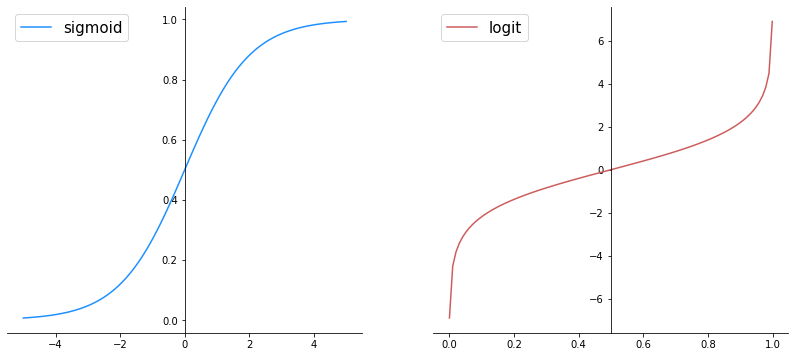

In [7]:
# Plot sigmoid and logit
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
Xplot = np.linspace(-5, 5, 100)
Yplot = sigmoid(Xplot)
ax[0].plot(Xplot, Yplot, color='dodgerblue', label='sigmoid')
Xplot = np.linspace(0.001, 0.999, 100)
Yplot = logit(Xplot)
ax[1].plot(Xplot, Yplot, color='indianred', label='logit')
for i in range(2):
    ax[i].legend(loc='best', fontsize=15)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_position('center')
plt.show(fig)

### 3.2 The cost function $J(\theta)$

The cost function is the following

\begin{equation}
    J_\theta = -\frac{1}{m} \sum_{i=1}^m y_i \log(\sigma(x_i^T\theta)) + (1-y_i) \log(1 -\sigma(x_i^T\theta))
\end{equation}

In a matrix notation

\begin{equation}
    J_\theta = -\frac{1}{m} [Y^T\log(\sigma(X\theta)) + ({\bf 1}-Y)^T\log(1 -\sigma(X\theta))]
\end{equation}

In [8]:
# Dependence on X,y is implicit
# X, y are defined globally
def computeCost(theta):
    J1 = np.dot(y.T, np.log(sigmoid(X.dot(theta))))
    J2 = np.dot((1-y).T,np.log(1-sigmoid(X.dot(theta))))
    return (-1/X.shape[0]) * (J1 + J2)

In [9]:
def test_computeCost():
    # test 1
    theta, cost = [0, 0, 0], 0.6931471
    if np.abs(computeCost(theta)-cost) < 1e-5:
        print("test 1 passed")
    else:
        raise ValueError("test 1 not passed!")
        
    # test 2
    theta, cost = [-0.01, 0.05, 0], 1.092916
    if np.abs(computeCost(theta)-cost) < 1e-5:
        print("test 2 passed")
    else:
        raise ValueError("test 2 not passed!")
        
test_computeCost()

test 1 passed
test 2 passed


### 3.3 The gradient function

Let's compute the gradient of the cost function.

\begin{equation}
    J_\theta = -\frac{1}{m} \sum_{i=1}^m y_i \log(\sigma(x_i^T\theta)) + (1-y_i) \log(1 -\sigma(x_i^T\theta))
\end{equation}


\begin{equation}
    J_\theta = -\frac{1}{m} [Y^T\log(\sigma(X\theta)) + ({\bf 1}-Y)^T\log(1 -\sigma(X\theta))]
\end{equation}

The sigmoid function has the nice property that
\begin{equation}
    \sigma'(z) = \sigma(z)(1-\sigma(z))
\end{equation}

Lets do it for one sample.
\begin{align}
    \nabla \log(\sigma(x_i^\top \cdot)) (\theta) &= \frac{x_i \nabla \sigma(x_i^\top \theta)}{\sigma(x_i^\top  \theta)} \\
    & = x_i (1-\sigma(x_i^\top \theta))
\end{align}

Doing the same for the right part and for all samples, the gradient is
\begin{align}
    \nabla J(\theta) &= -\frac{1}{m} \sum_{i=1}^m y_i x_i (1-\sigma(x_i^\top \theta)) - (1-y_i) x_i \sigma(x_i^\top \theta) \\
    &= -\frac{1}{m} \sum_{i=1}^m x_i (y_i - \sigma(x_i^\top \theta))
 \end{align}

In matrix form it takes the concise form
\begin{equation}
   \nabla J(\theta) = - \frac{1}{m} X^\top [Y - \sigma(X \theta)]
\end{equation}

In [10]:
# Dependence on X,y is implicit
# X, y are defined globally
def computeGrad(theta):
    # Computes the gradient of the cost with respect to
    # the parameters.
    
    return (-1/X.shape[0]) * np.dot(X.T, (y - sigmoid(X.dot(theta))))

In [11]:
def test_computeGrad():
    # test 1
    theta, grad = [0, 0, 0], np.array([ -0.1, -12.00921659, -11.26284221])
    if np.sum(np.abs(computeGrad(theta)-grad)) < 1e-5:
        print("test 1 passed")
    else:
        raise ValueError("test 1 not passed!")
        
    # test 2
    theta, grad = [0.02, 0, -0.04], np.array([-0.51775522, -39.39901278, -39.85199474])
    if np.sum(np.abs(computeGrad(theta)-grad)) < 1e-5:
        print("test 2 passed")
    else:
        raise ValueError("test 2 not passed!")
        
test_computeGrad()

test 1 passed
test 2 passed


### 3.4 Solve the optimization problem (i.e fit the model to the data)

In [12]:
# Initial value
theta = [0, 0, 0]

# Run minimize() to obtain the optimal theta
Result = op.minimize(fun=computeCost, x0=theta, 
                     method = 'TNC', jac=computeGrad);

theta = Result.x

In [13]:
Result

     fun: 0.2034977015894742
     jac: array([9.22909509e-09, 1.05007760e-07, 4.90380175e-07])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 36
     nit: 17
  status: 0
 success: True
       x: array([-25.1613187 ,   0.20623159,   0.20147149])

### 3.5 Visualize the fit

The decision boundary is given by

\begin{equation}
\sigma(\theta^T x) = 0.5 \iff \theta^T x = 0
\end{equation}

i.e
\begin{equation}
  x_2 = -\frac{\theta_1}{\theta_2}x_1 - \frac{\theta_0}{\theta_2}
\end{equation}

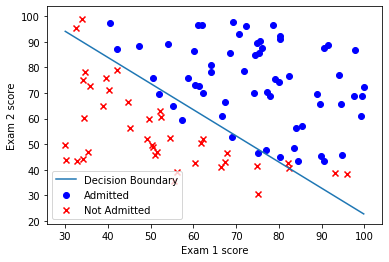

In [14]:
# Plot the decision boundary
plot_x = np.array([min(X[:, 1]), max(X[:, 1])])
plot_y = (- 1.0 / theta[2]) * (theta[1] * plot_x + theta[0])
plt.plot(plot_x, plot_y)
plt.scatter(X[pos, 1], X[pos, 2], marker='o', c='b')
plt.scatter(X[neg, 1], X[neg, 2], marker='x', c='r')
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend(['Decision Boundary', 'Admitted', 'Not Admitted'])
plt.show()

### 3.6 Evaluate the model

In [15]:
def predict(theta, X):
    # Predict whether the label is 0 or 1 using learned logistic 
    # regression parameters theta. The threshold is set at 0.5
    
    prob = sigmoid(X.dot(theta))
    pred = np.where(prob >= 0.5, 1, 0)
    return pred

In [16]:
def test_predict():
    # test 1
    X_test, y_pred = np.array([[1,40, 20], [1,40,80], [1,80,80]]), np.array([0,0,1])
    if np.sum(np.abs(y_pred - predict(Result.x, X_test))) == 0:
        print("test 1 passed")
    else:
        raise ValueError("test 1 not passed!")

    # test 2
    X_test, y_pred = np.array([[1,70, 50], [1,70,40]]), np.array([0,0])
    if np.sum(np.abs(y_pred - predict(Result.x, X_test))) == 0:
        print("test 2 passed")
    else:
        raise ValueError("test 2 not passed!")
        
test_predict()

test 1 passed
test 2 passed


In [17]:
# Compute accuracy on the training set
p = predict(Result.x, X)
counter = 0
for i in range(y.size):
    if p[i] == y[i]:
        counter += 1
print('Train Accuracy: {:.2f}'.format(counter / float(y.size) * 100.0))

Train Accuracy: 89.00
